<a href="https://colab.research.google.com/github/genova-25/Genova-project/blob/main/intern_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

            timestamp       base  machine  cooling      total
0 2025-01-01 00:00:00  52.483571        0       20  71.100928
1 2025-01-01 00:05:00  53.238443        0       20  88.468741
2 2025-01-01 00:10:00  48.829233        0       20  66.487864
3 2025-01-01 00:15:00  57.896064        0       20  85.570411
4 2025-01-01 00:20:00  47.652628        0       20  73.078229


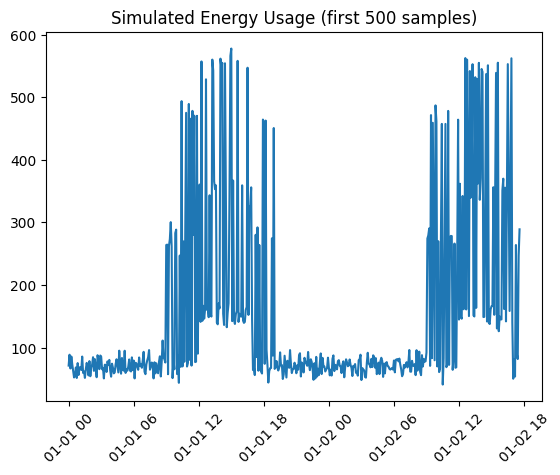

Train shape: (1132, 24, 3) Test shape: (284, 24, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 38053.2031 - val_loss: 44873.0820
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 39709.7422 - val_loss: 43644.7656
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 37247.7227 - val_loss: 40556.3945
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 31662.9121 - val_loss: 36028.1836
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 27209.1152 - val_loss: 30801.0371


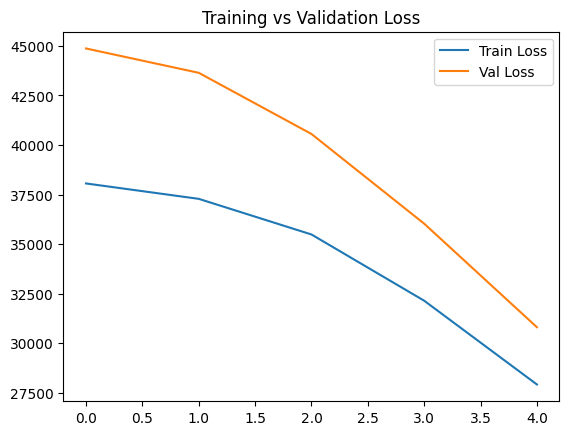

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


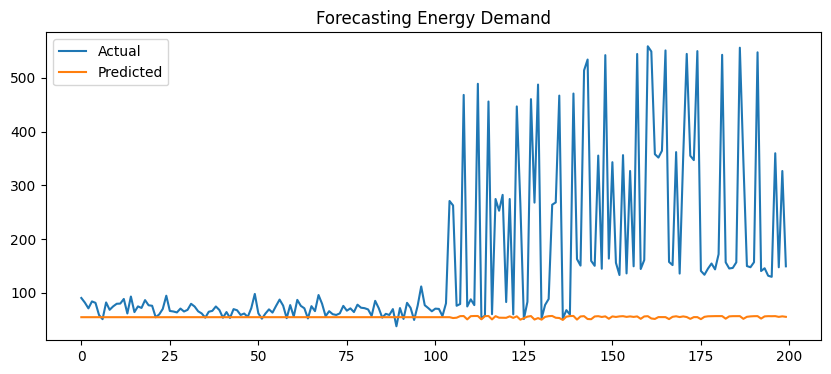

Predicted demand: 54.50 W -> Usage normal. No action needed.
Predicted demand: 54.46 W -> Usage normal. No action needed.
Predicted demand: 54.50 W -> Usage normal. No action needed.
Predicted demand: 54.51 W -> Usage normal. No action needed.
Predicted demand: 54.52 W -> Usage normal. No action needed.
Estimated cost savings: 30093.26 units


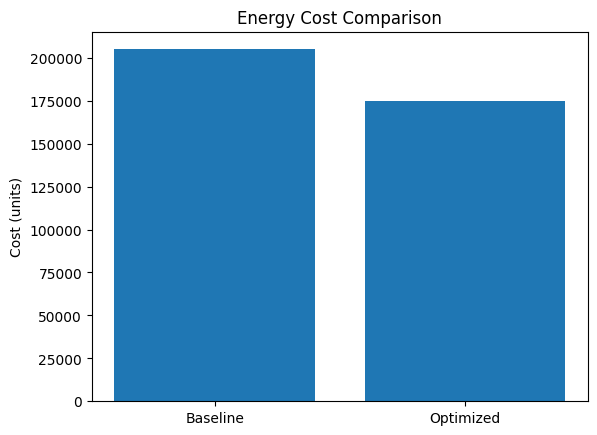

In [ ]:
# --- AI-based Energy Optimizer for Rural MSMEs ---
# Google Colab Implementation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Simulate IoT Energy Data ----------------------
np.random.seed(42)

def generate_energy_data(days=5):
    timestamps = pd.date_range(start="2025-01-01", periods=days*24*12, freq="5min")
    data = []
    for ts in timestamps:
        hour = ts.hour
        # Base load (lighting, small devices)
        base = 50 + np.random.normal(0, 5)
        # Machine usage pattern
        if 9 <= hour <= 18:
            machine = np.random.choice([0, 200, 400], p=[0.5, 0.3, 0.2])
        else:
            machine = 0
        # AC/fans
        cooling = 100 if 12 <= hour <= 16 else 20
        noise = np.random.normal(0, 10)
        total = max(0, base + machine + cooling + noise)
        data.append([ts, base, machine, cooling, total])
    df = pd.DataFrame(data, columns=["timestamp", "base", "machine", "cooling", "total"])
    return df

df = generate_energy_data()
print(df.head())

plt.plot(df["timestamp"][:500], df["total"][:500])
plt.xticks(rotation=45)
plt.title("Simulated Energy Usage (first 500 samples)")
plt.show()

# 2. Prepare Data for LSTM -------------------------
sequence_length = 24  # past 24 samples (~2 hours)
features = ["base", "machine", "cooling"]
target = "total"

X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df[features].iloc[i:i+sequence_length].values)
    y.append(df[target].iloc[i+sequence_length])
X, y = np.array(X), np.array(y)

train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 3. Build & Train Model ---------------------------
model = Sequential([
    LSTM(64, input_shape=(sequence_length, len(features))),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Plot training curve
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# 4. Forecasting -----------------------------------
y_pred = model.predict(X_test)

plt.figure(figsize=(10,4))
plt.plot(y_test[:200], label="Actual")
plt.plot(y_pred[:200], label="Predicted")
plt.legend()
plt.title("Forecasting Energy Demand")
plt.show()

# 5. Optimizer & Suggestions -----------------------
def suggest_actions(prediction, threshold=300, lang="en"):
    if lang == "en":
        if prediction > threshold:
            return "High usage expected. Shift non-essential tasks."
        else:
            return "Usage normal. No action needed."
    elif lang == "ta":  # Tamil
        if prediction > threshold:
            return "அதிக மின்சாரம் தேவைப்படும். தேவையற்ற பணிகளை மாற்றவும்."
        else:
            return "சாதாரண மின்சார பயன்பாடு. எவ்வித நடவடிக்கையும் தேவையில்லை."
    else:
        return "Language not supported."

# Example suggestions
for i in range(5):
    pred = y_pred[i][0]
    print(f"Predicted demand: {pred:.2f} W -> {suggest_actions(pred, lang='en')}")

# 6. Energy Savings Simulation ---------------------
baseline_cost = np.sum(y_test) * 5  # assume 5 currency units per kWh
optimized_cost = np.sum(np.minimum(y_test, 300)) * 5

savings = baseline_cost - optimized_cost
print(f"Estimated cost savings: {savings:.2f} units")

plt.bar(["Baseline", "Optimized"], [baseline_cost, optimized_cost])
plt.title("Energy Cost Comparison")
plt.ylabel("Cost (units)")
plt.show()
